# Convolutional neural net for playing PacMan using Q-Learning
## Author : Ankit Gupta

In [2]:
# before proceeding please install 'OpenAI Gym' 

import gym
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as anime

env = gym.make("MsPacman-v0")

(210, 160, 3)
action_space : Discrete(9)


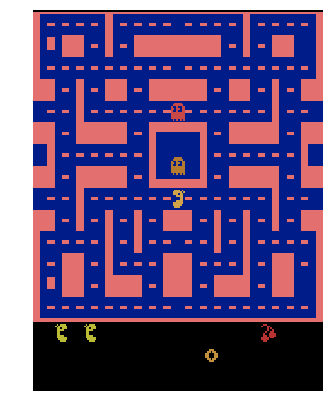

In [3]:
# starting a new game and plotting the frame

obs = env.reset()
print(obs.shape) #[ht, wd, channels]

plt.figure(figsize=(7, 7))
plt.imshow(obs)
plt.axis('off')

# 9 possible actions in Pacman : 0,...,8
# 0: no change, 1: up, 2: right, 3: left, 4: down, ...
print('action_space :', env.action_space)

original obs shape : (210, 160, 3)
new obs shape : (84, 80, 3)
0 228 -128 100


(-0.5, 79.5, 83.5, -0.5)

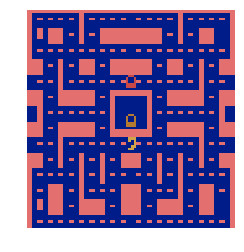

In [6]:
# reducing the image size, crop for faster training

def preprocess(obs):
    img = obs[1:168:2, : : 2, :] # crop and downsize
    img = img - 128 # normalize between -128 and 127
    img = img.astype('int8') # saves memory
    return img

print('original obs shape :', obs.shape)
print('new obs shape :', preprocess(obs).shape)
print(obs.min(), obs.max(), preprocess(obs).min(), preprocess(obs).max())

plt.imshow((preprocess(obs) + 128).astype('uint8')) # plt doesn't plot 'int8'
plt.axis('off')

In [7]:
# constructing the online and target Q-nets

import tensorflow as tf

input_height = 84
input_width = 80
n_channels = 3 
conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [(8, 8), (4, 4), (3, 3)]
conv_strides = [4, 2, 1]
conv_pads = ['SAME']*3
conv_activation = [tf.nn.relu]*3
n_hidden_in = conv_n_maps[2] * 11 * 10 # conv3 has 64 maps of 11x10 each
n_hidden = 512
hidden_activation = tf.nn.relu

# we only allow 4 actions : 1: up, 2: right, 3: left, 4: down
n_outputs = 4  # (in output vector, map is changed to 0: up, 1: right, 2: left, 3: down) 

# He-initializer
he_init = tf.contrib.layers.variance_scaling_initializer()
outputs_initializer = tf.contrib.layers.variance_scaling_initializer()

In [8]:
# as we have to build 2 identitical Q-nets, lets define a func for it 

def q_net(X_inp, name):
    X_inp_normalized = tf.cast(X_inp, dtype='float32') / 128.0
    
    with tf.variable_scope(name) as scope:
        # all vars names will be prefixed with 'name'
        
        conv1 = tf.layers.conv2d(X_inp_normalized, filters=conv_n_maps[0], kernel_size=conv_kernel_sizes[0], 
                                 strides=conv_strides[0], padding=conv_pads[0], 
                                 activation=conv_activation[0], kernel_initializer=he_init)
        conv2 = tf.layers.conv2d(conv1, filters=conv_n_maps[1], kernel_size=conv_kernel_sizes[1], 
                                 strides=conv_strides[1], padding=conv_pads[1], 
                                 activation=conv_activation[1], kernel_initializer=he_init)
        conv3 = tf.layers.conv2d(conv2, filters=conv_n_maps[2], kernel_size=conv_kernel_sizes[2], 
                                 strides=conv_strides[2], padding=conv_pads[2], 
                                 activation=conv_activation[2], kernel_initializer=he_init)
        hidden = tf.layers.dense(tf.reshape(conv3, shape=(-1, n_hidden_in)), 
                                 n_hidden, activation=hidden_activation, kernel_initializer=he_init)
        outputs = tf.layers.dense(hidden, n_outputs, kernel_initializer=outputs_initializer)
        
        trainbale_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=name)
        
    return outputs, trainbale_vars


tf.reset_default_graph()

X_state = tf.placeholder(dtype='int8', shape=(None, input_height, input_width, n_channels), name='X')

q_vals_online, vars_online = q_net(X_state, 'online')
q_vals_target, vars_target = q_net(X_state, 'target')

In [15]:
# define a function for copying online vars to target vars

assign_ops = []

for i, var in enumerate(vars_target):
    assign_ops.append(tf.assign(var, vars_online[i]))
    
copy_online_to_target = tf.group(*assign_ops)

In [16]:
# defining loss func and training ops

learning_rate = 0.001

X_action = tf.placeholder('uint8', shape=(None)) # actions taken by online q-net
y = tf.placeholder('float32', shape=(None, 1))  # q-val estimates using target q-net

q_val_action = tf.reduce_sum(q_vals_online * tf.one_hot(X_action, n_outputs),
                            axis=1, keep_dims=True) #[batch_size, 1]

# using L1 loss as in L2 loss the gradients are too unstable
loss = tf.reduce_mean(tf.abs(q_val_action - y)) # L1 loss

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

# checking for exploding grads
bottom_grads = optimizer.compute_gradients(loss, var_list=[vars_online[0]])
bottom_grads_norm = tf.norm(bottom_grads, ord=1) # reflects changes in smaller gradients

#saver
saver = tf.train.Saver()

#init
init = tf.global_variables_initializer()

In [17]:
# defining helper functions and game memory

from collections import deque

max_mem_size = 2000
game_memory = deque([], max_mem_size) # a queue with max len

epsilon0 = 1.0
epsilon_min = 0.9
eps_decay_steps = 2000000

def epsilon_greedy(step, q_vals_eval):
    # this is more relevant if you have the patience for training the net for a LONG time
    #unfortunately we will not be doing so: hence epsilon_min is kept very high
    epsilon = max(epsilon_min, epsilon0 - (epsilon0 - epsilon_min)*(step / eps_decay_steps))
    if np.random.random() < epsilon:
        return np.random.choice(n_outputs)
    else:
        return np.argmax(q_vals_eval)
    
def get_next_batch(batch_size, n_steps_train):
    indices = np.random.permutation(-np.arange(1, n_steps_train))[:batch_size]
    (batch_state, batch_action, batch_reward, batch_next_state, batch_continue) = ([], [], [], [], [])
    for idx in indices:
        state, action, reward, next_state, cont = game_memory[idx]     
        batch_state.append(state)
        batch_action.append(action)
        batch_reward.append(reward)
        batch_next_state.append(next_state)
        batch_continue.append(cont)
    batch_state = np.array(batch_state)
    batch_next_state = np.array(batch_next_state)
    batch_action = np.array(batch_action).reshape(batch_size, 1)
    batch_reward = np.array(batch_reward).reshape(batch_size, 1)
    batch_continue = np.array(batch_continue).reshape(batch_size, 1)
    return batch_state, batch_action, batch_reward, batch_next_state, batch_continue

In [44]:
# starting a training session 

n_steps = 5000000     # num steps to train for
n_steps_train = 15     # train online q-net after these many steps
n_steps_copy = 3000   # copy online net to target after these many steps
discount_rate = 0.999999 
batch_size = 5 
skip_start = 85       # skip the start of every game (it's just waiting time in PacMan)
training_start = 60   # start training after these many steps 
timer = 8             # update action after these life steps, this was determined using experiments

sess = tf.InteractiveSession()
init.run()

step = 0
done = True # has a game ended?
game_memory = deque([], max_mem_size)

# vars for keeping track of training progress
opt_actions= deque([], n_steps_train)
game_reward = 0  # total reward scored in a game
n_games = 0
last_10_losses = deque([], 10)  # a queue for storing last 10 training losses

In [45]:
from collections import Counter

while step < n_steps:
    step += 1
    
    if done:
        # start a  new game
        obs = env.reset()
        # skip the start of each game as in pacman its just waiting
        for skip in range(skip_start): 
                obs, reward, done, info = env.step(0)
        state = preprocess(obs)
        lives_left = 3
        game_reward = 0
        life_step = 0
        n_games += 1
        
    
    # determine the action using e-greedy policy on online q_net
    q_vals_eval = q_vals_online.eval(feed_dict={X_state: state.reshape(1, input_height, input_width, n_channels)})[0]
    opt_actions.append(1 + np.argmax(q_vals_eval))
    
    # update the action every 8 life steps
    if life_step % timer == 0:
        action = epsilon_greedy(step, q_vals_eval)
            
    #execute the action
    (obs, reward, done, info) = env.step(action + 1)
    next_state = preprocess(obs)
    life_step += 1
    game_reward += int(reward)
    
    # record this step in game memory
    game_memory.append((state, action, reward, next_state, 1 - done))
    
    # skip the start of each new life as in pacman its just waiting
    if lives_left != info['ale.lives']:
        lives_left = info['ale.lives']
        life_step = 0
        for skip in range(35): 
            obs, reward, done, info = env.step(0)
    
    if step < training_start:
        # there are not enough game memories to train usefully
        continue
        
    if step % n_steps_train == 0:
        # train the online q_net 
        batch_state, batch_action, batch_reward, batch_next_state, batch_continue = get_next_batch(batch_size, n_steps_train)
        # estimate the q_online vals using reward and q_target val
        q_target_eval = q_vals_target.eval(feed_dict={X_state: batch_next_state}) # [batch_size, n_outputs]
        q_target_eval_max = np.max(q_target_eval, axis=1).reshape(-1, 1) # [batch_size, 1]
        q_est = batch_reward + discount_rate * q_target_eval_max * batch_continue # [batch_size, 1]
        loss_eval, _, b_grads_norm = sess.run([loss, training_op, bottom_grads_norm], 
                                             feed_dict={X_state: batch_state, 
                                                        X_action: batch_action.reshape(-1), y: q_est}
                                            )
        # queue the loss
        last_10_losses.append(loss_eval)
        
        if step % 300 == 0:
            # print the mean of last 10 train losses, bottom grads norm , etc
            print(step, ':', '%.1f' % np.mean(last_10_losses), dict(Counter(opt_actions)), b_grads_norm, end='  ')
            opt_actions= deque([], n_steps_train)
            
        # exploding bottom layer grads
        if loss_eval > 2e14 or b_grads_norm > 2e14:
            print('-------------DIVERGED----------------')
            break
        
    if step % n_steps_copy == 0:
        # copy online q_net vars to target q_net
        sess.run(copy_online_to_target)
        print('|copy|', end=' ')

300 : 1.0 {2: 15} 700.769  600 : 1.3 {1: 15} 739.582  900 : 0.9 {1: 15} 704.016  

KeyboardInterrupt: 

In [44]:
# store the model

saver.save(sess, './datasets/Pacman/pacman.ckpt')

In [23]:
# playing using the online q-net

import time

#sess = tf.InteractiveSession()
#saver.restore(sess, './datasets/Pacman/pacman.ckpt')

n_max_steps = 5000
frames = [] # will store the game frames, can be converted to video
game_reward = 0

# start a  new game
obs = env.reset()

# skip the start of each life as in pacman its just waiting
for skip in range(skip_start): 
    obs, reward, done, info = env.step(0)

lives_left = 3

for stp in range(n_max_steps):
    state = preprocess(obs)    
    # determine the action using online q_net
    q_vals_eval = q_vals_online.eval(feed_dict={X_state: state.reshape(1, input_height, input_width, n_channels)})[0]
    action = np.argmax(q_vals_eval)
    # execute the action
    obs, reward, done, info = env.step(1 + action)
    
    # skip the start of each life as in pacman its just waiting
    if lives_left != info['ale.lives']:
        lives_left = info['ale.lives']
        for skip in range(35): 
            obs, reward, done, info = env.step(0)
    
    print(1 + action, end=' ')
    frames.append(obs) # if you want to store the game as a vid
    game_reward += int(reward)
    env.render()
    time.sleep(0.05) # to slowdown the game
    # check if game ended
    if done:
        break

print('game_score :', game_reward)
# 0:no change, 1:t, 2:r, 3:l, 4:d 

1 1 1 1 1 1 1 1 1 1 1 4 4 4 4 4 4 2 4 4 3 1 4 1 1 1 2 4 2 4 3 1 4 4 4 4 1 4 4 4 4 4 4 1 4 1 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 1 4 4 4 4 4 4 4 4 4 4 1 1 3 1 1 1 4 4 1 2 3 4 2 4 4 4 4 2 1 1 3 4 3 3 1 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 4 4 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 1 4 4 3 4 4 4 3 3 4 4 3 4 4 4 4 3 3 1 3 4 3 3 4 3 3 4 4 3 4 3 4 3 4 3 3 4 4 4 4 4 3 1 4 4 4 3 4 3 3 4 3 1 1 4 3 3 3 3 4 4 3 4 4 4 3 3 1 1 3 3 3 3 3 3 3 3 3 3 3 3 1 4 2 2 3 1 2 3 2 3 1 4 3 1 4 4 3 2 2 3 2 4 4 2 4 4 4 4 4 4 4 3 4 4 3 4 3 3 3 3 4 4 3 3 3 3 3 3 3 3 3 3 4 4 3 3 4 1 1 3 4 4 2 2 1 4 3 4 3 2 1 4 4 3 4 4 4 3 3 3 4 3 4 4 4 4 1 2 3 3 2 4 4 4 4 4 4 4 4 4 4 3 4 3 2 4 4 4 4 4 3 4 4 4 4 4 4 3 3 1 3 4 2 4 4 4 3 4 4 4 4 4 4 4 4 4 4 1 1 1 4 4 3 3 4 1 3 3 3 3 4 4 2 4 2 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 3 4 3 4 3 4 4 4 4 4 3 4 4 1 1 4 4 4 4 4 4 4 4 3 4 3 4 4 3 4 3 3 3 4 4 1 1 4 4 4 4 4 4 4 3 4 4 3 4 1 2 1 1 4 4 4 4 4 3 4 3 3 4 2 2 2 2 4 4 4 2 2 1 1 4 4 4 2 4 1 3 1 1 3 4 1 3 3 3 4 2 4 4 4 

In [26]:
# close the rendering window

env.render(close=True)

In [41]:
# restore a saved model

saver.restore(sess, './datasets/Pacman/dec5/pacman.ckpt')

INFO:tensorflow:Restoring parameters from ./datasets/Pacman/dec5/pacman.ckpt


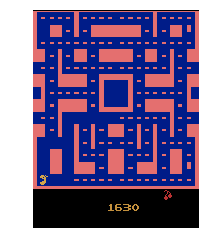

In [43]:
# saving the previous game as a video

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return anime.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)

plot_animation(frames).save('PacMan.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

In [57]:
# NOTES:

# keep only 4 actions: l, r, u, d
# if timer=8 is not used it'll never see states that are far spread out

# chosing a random action after every 8 steps (and using it for 8 steps) gives a mean reward of 470.5
# mean rewards of various timer vals
# {timer: mean rwd} {3: 339.0833333333333, 4: 385.25, 5: 418.8333333333333, 6: 425.8333333333333, 7: 456.6666666666667, 8: 470.5, 9: 446.6666666666667}

#cnn, channels = 3, L1 LOSS, learning_rate = 0.001 n_steps_train = 15 n_steps_copy = 3000 discount_rate = 0.99999 batch_size = 5 
#skip_start = 85 training_start = 60  timer = 8, GradDesc